# 在下游任務上 Fine-tune BERT
### 以 Natural Language Inference 為例
目標：給定一個假新聞標題 text_a，以及另一則新聞標題 text_b，訓練一個模型使它具備推論 text_a 和 text_b 之間的關係的能力。

關係的種類分為 agreed、disagreed、unrelated，分別表示 text_b 和 text_a 有相同的觀點或立場、不同的觀點或立場，或是兩者無關。

也就是說，本次的下游任務是一個分類問題，類別的數量共有三種！

In [1]:
!pip install transformers

### 讀取數據並分割為 train, validation 及 test 三個檔案
由於這個 dataset 最初是一個 kaggle 的競賽 (https://www.kaggle.com/c/fake-news-pair-classification-challenge)

因此官方公布的 test set 上是沒有 label 的，為了能測試 model 一般化的能力，助教已經從大的 training set 中切出 validation 及 test set。並且為了讓訓練速度快一點，我們只取5,000筆資料來訓練、1000筆驗證、1000筆測試。


In [2]:
import pandas as pd
# 讀取資料集
train = pd.read_csv("https://raw.githubusercontent.com/dinobby/NLP110_Lab4/main/train.tsv", sep='\t').sample(n=5000)
valid = pd.read_csv("https://raw.githubusercontent.com/dinobby/NLP110_Lab4/main/valid.tsv", sep='\t').sample(n=1000)
test = pd.read_csv("https://raw.githubusercontent.com/dinobby/NLP110_Lab4/main/test.tsv", sep='\t').sample(n=1000)
train.head()

,text_a,text_b,label
5286,李小璐小腹隆起，这是怀上二胎了？,看完这些照片便知李小璐疑似二胎在侧，看来好事将近,agreed
6519,济宁采暖面积按使用面积计价,法院力挺马蓉后公开道歉，如果力挺王宝强会道歉吗？,unrelated
14894,张一山生病了，暂退娱乐圈，到底怎么了，网友称看一下脖子就知道,大红大紫的张一山为什么要退出娱乐圈，看完他脖子你就知道了！,agreed
27579,关于恋爱的签名|想和你去爱尔兰，唯一禁止离婚的国家,肚子太大？节食减肥伤身体？减肥专家教你1招快速瘦身,unrelated
26073,手机号能算出你的年龄，你知道吗，怎么了？怎么了？,手机号可以算出你的年龄,agreed


In [3]:
print("訓練樣本數：", len(train))
print("驗證樣本數：", len(valid))
print("測試樣本數：", len(test))

訓練樣本數： 5000
驗證樣本數： 1000
測試樣本數： 1000


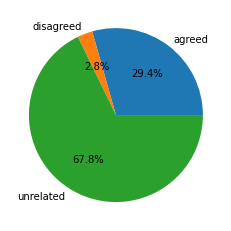

In [4]:
# 看一下訓練集上 label 的分布，才能大概知道我們的 baseline 在哪裡！
import matplotlib.pyplot as plt
num_agreed = sum(train.label == 'agreed')
num_disagreed = sum(train.label == 'disagreed')
num_unrelated = sum(train.label == 'unrelated')
labels = ['agreed', 'disagreed', 'unrelated']
size = [num_agreed, num_disagreed, num_unrelated]
plt.pie(size, labels=labels, autopct='%1.1f%%')
plt.show()

## 動手寫一個自定義的 Dataset Class
`torch.utils.data` 中的 `Dataset` 是一個非常好用的工具，可以幫助你輕鬆的把 raw data 轉成 pytorch 能一批一批接收的形式 

In [12]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset
from IPython.display import clear_output

# 取得此預訓練模型所使用的 tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

class FakeNewsDataset(Dataset):
    # 讀取前處理後的 tsv 檔並初始化一些參數
    def __init__(self, mode, df, tokenizer):
        assert mode in ["train", "valid", "test"]
        self.mode = mode
        self.df = df.fillna("")
        self.len = len(self.df)
        self.label_map = {'agreed': 0, 'disagreed': 1, 'unrelated': 2}
        self.tokenizer = tokenizer
    
    # 這裡需要定義回傳一筆訓練 / 測試數據的函式，
    # 也就是當以 [idx] 來 index Dataset 時，要回傳的東西
    def __getitem__(self, idx):
        if self.mode == "test":
            text_a, text_b = self.df.iloc[idx, :2].values
            label_tensor = None
        else:
            text_a, text_b, label = self.df.iloc[idx, :].values
            # 將 label 文字也轉換成索引方便轉換成 tensor，
            # {agreed': 0, 'disagreed': 1, 'unrelated': 2}
            label_id = self.label_map[label]
            label_tensor = torch.tensor(label_id)
            
        # [TODO1]: 將 input sentence 轉成 [CLS] + text_a + [SEP] + text_b + [SEP]
        # ==============================================
        #word_pieces = tokenizer.encode('[CLS] ' + text_a + ' [SEP] ' + text_b + ' [SEP]')
        text = '[CLS]' + text_a + ' [SEP]' + text_b + ' [SEP]'
        word_pieces = tokenizer.tokenize(text)
        # ==============================================
        
        # 將剛剛做好的 input sentence 轉換成索引序列
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
        
        # [TODO2]: 將第一句+ [SEP] 的 token 位置設為 0，其他為 1 來表示句子間的segment
        # ==============================================
        segments_tensor = torch.tensor([0] * len(text_a) + [1] * len(text_b),dtype=torch.long)
        
        # ==============================================
        
        return (tokens_tensor, segments_tensor, label_tensor)
    
    def __len__(self):
        return self.len
    
# 初始化 Dataset，使用中文 BERT 斷詞
trainset = FakeNewsDataset("train", train, tokenizer=tokenizer)
validset = FakeNewsDataset("valid", valid, tokenizer=tokenizer)

In [13]:
# 選擇第一個樣本出來，看看原始 input 是怎麼被轉換成 BERT 相容的格式的
sample_idx = 0

# 將原始文本拿出做比較
text_a, text_b, label = trainset.df.iloc[sample_idx].values

# 利用剛剛建立的 Dataset 取出轉換後的 id tensors，
# 經過我們自定義的 Dataset 後，trainset 現在已經是個 iterable 的 object，
# 可以用編號來索引你想要去得的位置的 id tensors
tokens_tensor, segments_tensor, label_tensor = trainset[sample_idx]

# 將 tokens_tensor 還原成文本
tokens = tokenizer.convert_ids_to_tokens(tokens_tensor.tolist())
combined_text = "".join(tokens)

print(f"""[原始文本]
句子 1：{text_a}
句子 2：{text_b}
分類  ：{label}

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：{tokens_tensor}

segments_tensor：{segments_tensor}

label_tensor   ：{label_tensor}

--------------------

[還原 tokens_tensors]
{combined_text}
""")

[原始文本]
句子 1：李小璐小腹隆起，这是怀上二胎了？
句子 2：看完这些照片便知李小璐疑似二胎在侧，看来好事将近
分類  ：agreed

--------------------

[Dataset 回傳的 tensors]
tokens_tensor  ：tensor([ 101, 3330, 2207, 4466, 2207, 5592, 7384, 6629, 8024, 6821, 3221, 2577,
         677,  753, 5522,  749, 8043,  102, 4692, 2130, 6821,  763, 4212, 4275,
         912, 4761, 3330, 2207, 4466, 4542,  849,  753, 5522, 1762,  904, 8024,
        4692, 3341, 1962,  752, 2199, 6818,  102])

segments_tensor：tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

label_tensor   ：0

--------------------

[還原 tokens_tensors]
[CLS]李小璐小腹隆起，这是怀上二胎了？[SEP]看完这些照片便知李小璐疑似二胎在侧，看来好事将近[SEP]



In [65]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# create_mini_batch 的參數 `samples` 是一個 list，裡頭的每個 element 都是
# 剛剛定義的 `FakeNewsDataset` 回傳的一個樣本，每個樣本都包含 3 tensors：
# - tokens_tensor
# - segments_tensor
# - label_tensor
# 它會對前兩個 tensors 作 zero padding，並產生前面說明過的 masks_tensors
def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    
    # 測試集有 labels
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
    
    # [TODO3]: 將 token_tensors 及 segments_tensors zero padding 到同樣長度，
    # hint: 可以使用 import的 pad_sequence，記得 batch_first 要設為 True
    #================================================
    max_tok = 0
    for i in range(1,len(tokens_tensors)):
      if tokens_tensors[i].shape > tokens_tensors[max_tok].shape:
        max_tok = i
    temp = pad_sequence([segments_tensors[0],tokens_tensors[max_tok]],batch_first=True)
    segments_tensors[0] = temp[0]
    tokens_tensors = pad_sequence(tokens_tensors,batch_first=True)
    segments_tensors = pad_sequence(segments_tensors,
                                    batch_first=True)
    #================================================
    
    # [TODO4] 製作 attention masks，將 tokens_tensors 裡頭不為 zero padding
    # 的位置設為 1，讓 BERT 只關注這些位置的 tokens
    # ================================================
    # 先製作一條長度和 token_tensors 一樣的 0 張量
    masks_tensors = torch.zeros(tokens_tensors.shape,
                                dtype=torch.long)
        
    # 接著將不為 zero padding 的位置設為1 (由同學實作)
    # hint: 可以使用 tensor.masked_fill()
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0,1)
    # ================================================
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids


# 初始化一個每次回傳 BATCH_SIZE 個訓練樣本的 DataLoader
# 利用 `collate_fn` 將 list of samples 合併成一個 mini-batch 是關鍵
trainloader = DataLoader(trainset, batch_size=128, 
                         collate_fn=create_mini_batch)

validloader = DataLoader(validset, batch_size=256, 
                         collate_fn=create_mini_batch)

In [66]:
data = next(iter(trainloader))

tokens_tensors, segments_tensors, \
    masks_tensors, label_ids = data

print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
label_ids.shape        = {label_ids.shape}
{label_ids}
""")

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tokens_tensors.shape   = torch.Size([128, 63]) 
tensor([[ 101, 3330, 2207,  ...,    0,    0,    0],
        [ 101, 3845, 2123,  ...,    0,    0,    0],
        [ 101, 2476,  671,  ..., 8013,  102,    0],
        ...,
        [ 101,  671,  679,  ...,    0,    0,    0],
        [ 101, 3189, 3315,  ...,    0,    0,    0],
        [ 101, 3274, 2607,  ...,    0,    0,    0]])
------------------------
segments_tensors.shape = torch.Size([128, 63])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([128, 63])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 

## 資料準備完畢，模型在哪裡！
Hugging face 是一個非常佛心的團隊，整理並實現了許多 BERT 家族及其變種的模型，而且提供訓練好的參數可以直接載入，等於1等出生在新手村就能拿到99等的裝備！有了厲害的預訓練語言模型，機器就能更好的理解我們輸入的人類語言，也就是把離散的文字輸入轉化成考慮了上下文而產生的連續向量，具備這樣的武器，後續無論是要應對什麼樣的問題，難度都大大的降低了許多。

只要指定要載入的模型名稱(e.g., `bert-base-chinese`)，就可以直接從 hugging face 提供的 hub 將模型拉進來。各種變形和模型的名稱可以在 https://huggingface.co/transformers/pretrained_models.html 這個頁面找到！

In [67]:
# 載入一個預訓練好可以做中文多分類任務的模型，n_class = 3
from transformers import BertForSequenceClassification
from IPython.display import clear_output

NUM_LABELS = 3
model = BertForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=NUM_LABELS)

clear_output()

## 那 BertForSequenceClassification 裡面做了什麼呢？
我們可以看看 hugging face 官方文件中的原始碼片段，其實就是過了 BERT 並 dropout 之後，接上了一層 linear 把結果輸出的維度投影到 num_class！所以如果你想要拿 BERT 產生的 representation 再做更多更複雜的事，只要依樣畫葫蘆，繼承 PreTrainedBertModel，並將 Bert 的參數寫進BertModel(config)中，就能夠自己定義 forward pass 時要做的事情了，例如不要只用 `nn.Linear`，而是再過一個 `nn.Conv2d`？

In [ ]:
"""
class BertForSequenceClassification(PreTrainedBertModel):
    def __init__(self, config, num_labels=2):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits
"""

'\nclass BertForSequenceClassification(PreTrainedBertModel):\n    def __init__(self, config, num_labels=2):\n        super(BertForSequenceClassification, self).__init__(config)\n        self.num_labels = num_labels\n        self.bert = BertModel(config)\n        self.dropout = nn.Dropout(config.hidden_dropout_prob)\n        self.classifier = nn.Linear(config.hidden_size, num_labels)\n        self.apply(self.init_bert_weights)\n\n    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):\n        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)\n        pooled_output = self.dropout(pooled_output)\n        logits = self.classifier(pooled_output)\n\n        if labels is not None:\n            loss_fct = CrossEntropyLoss()\n            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))\n            return loss\n        else:\n            return logits\n'

In [57]:
%%time
from tqdm.notebook import tqdm
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for data in tqdm(dataloader):
            if next(model.parameters()).is_cuda:
                data = [t.to("cuda:0") for t in data if t is not None]
            
            if not compute_acc:
                # 只是單純要回傳預測值的話，不用計算準確度也不用紀錄 loss
                tokens_tensors, segments_tensors, masks_tensors = data[:3]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors)
                logits = outputs[0]
                _, pred = torch.max(logits.data, 1)
            else:
                # 否則就要計算 loss，這邊有一個小細節是 model 如果有吃 label 的話，
                # output[0]會變成是 loss，沒有吃 label 時 output[0] 會是 logits
                tokens_tensors, segments_tensors, masks_tensors, labels = data[:4]
                outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors,
                                labels=labels)
                loss = outputs[0]
                logits = outputs[1]
                _, pred = torch.max(logits.data, 1)
                running_loss += loss.item()
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                
            if predictions is None:
                predictions = pred
            else:
                predictions = torch.cat((predictions, pred))
    
    if compute_acc:
        acc = correct / total
        loss = running_loss / total
        return predictions, acc, loss
    
    return predictions
    
# 讓模型跑在 GPU 上並取得訓練集的分類準確率
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 這邊要記得確認 model 在 GPU 上運行 (投影片有說明)，否則會跑很久！
print("device:", device)
model = model.to(device)
_, train_acc, train_loss = get_predictions(model, trainloader, compute_acc=True)
print("train acc:", train_acc)
print("train loss:", train_loss)

device: cuda:0


  0%|          | 0/40 [00:00<?, ?it/s]

RuntimeError: ignored

## 開始訓練模型
由於模型才剛初始化，只讓他讀過一輪 data 沒有更新 weights 就要它產生預測，難怪準確度不高、輸給了 majority，也就是直接全部都猜 unrelated 的 0.678

如果讓模型多看幾次 data (多幾個 epochs)，多更新幾次權重，效果能提升到什麼程度呢？

In [ ]:
%%time
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 3  # 由於時間有限，訓練 3 輪看看表現如何就好
for epoch in range(EPOCHS):
    running_loss = 0.0
    for data in tqdm(trainloader):
        
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors, 
                        token_type_ids=segments_tensors, 
                        attention_mask=masks_tensors, 
                        labels=labels)

        loss = outputs[0]
        loss.backward()
        optimizer.step()

        # 紀錄當前 batch loss
        running_loss += loss.item()

    # 計算分類準確率
    _, train_acc, train_loss = get_predictions(model, trainloader, compute_acc=True)
    _, valid_acc, valid_loss = get_predictions(model, validloader, compute_acc=True)
    
    print('[epoch %d] train loss: %.3f, train acc: %.3f, valid loss: %.3f, valid acc: %.3f' %
          (epoch + 1, train_loss, train_acc, valid_loss, valid_acc))

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[epoch 1] train loss: 0.004, train acc: 0.811, valid loss: 0.002, valid acc: 0.817


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[epoch 2] train loss: 0.003, train acc: 0.852, valid loss: 0.002, valid acc: 0.824


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[epoch 3] train loss: 0.002, train acc: 0.881, valid loss: 0.001, valid acc: 0.846


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[epoch 4] train loss: 0.002, train acc: 0.909, valid loss: 0.001, valid acc: 0.838


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[epoch 5] train loss: 0.002, train acc: 0.894, valid loss: 0.002, valid acc: 0.812
CPU times: user 10min 50s, sys: 21.3 s, total: 11min 12s
Wall time: 11min 14s


## 儲存訓練好的模型
一般來說，我們應該在訓練的同時記錄最小的 validation loss 或最高的 validation accuracy，以此來決定儲存模型的時機，不過在這邊的 demo 中我們就直接存訓練完 5 個 epochs 過後的結果了。

In [ ]:
torch.save(model.state_dict(), 'checkpoint.pt')

要將訓練好的模型讀取回來，做預測或繼續訓練也都是很方便的：

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-chinese", num_labels=NUM_LABELS)
model.load_state_dict(torch.load("checkpoint.pt"))
model.to(device)
model.eval()
clear_output()

## 對測試集中的新樣本進行推論

In [ ]:
testset = FakeNewsDataset("test", test, tokenizer=tokenizer)
testloader = DataLoader(testset, batch_size=256, 
                        collate_fn=create_mini_batch)

# label 與 id 互相轉換的兩個 dictionary
label2idx = testset.label_map
idx2label = {v:k for k, v in label2idx.items()}

# 將測試集的 label 轉成 id，用來計算測試集上的準確度
test_y = test.label.apply(lambda x: label2idx[x]).values
print(test_y)

[2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 0 0 2 2 2 2 2 2 2 2
 2 0 0 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 0 0 2 2 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2
 2 2 0 0 2 2 2 0 0 0 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 0 2 0 2 0 2 2 2
 0 0 0 2 2 0 1 2 2 0 2 2 1 2 1 0 2 2 2 0 2 2 2 2 2 2 2 2 0 2 0 2 0 0 2 0 0
 2 0 0 0 2 0 0 2 0 0 0 0 0 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 2 2 0 0 2 2 2 0
 0 2 2 0 2 0 0 2 2 0 0 0 2 0 2 2 0 2 2 2 2 2 2 2 2 2 0 2 0 0 2 2 0 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 1 2 2 2 2 2 2 0 0 2 2 0 0 2 0 0 0 0 2 0 2 0
 2 2 2 0 2 0 2 2 0 0 2 0 0 0 0 0 2 2 2 2 2 2 0 2 2 2 1 2 2 2 0 2 2 2 0 2 2
 2 0 2 2 0 2 2 2 2 2 2 2 2 2 0 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 2
 2 2 2 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 2 2 2 1 2 2 0 1 0 0 2 2 2 1 2
 2 2 2 2 2 0 2 2 2 2 0 2 2 2 2 2 0 0 2 2 2 2 2 0 0 2 2 0 2 0 2 0 2 0 0 0 0
 0 0 0 0 2 0 2 0 2 0 2 0 2 2 2 2 2 2 2 2 0 1 2 2 1 2 0 2 2 0 0 0 0 0 2 0 0
 2 2 2 2 2 2 2 2 0 2 2 0 2 0 0 0 2 2 0 0 2 2 0 2 0 2 2 1 2 0 2 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 0 2 

In [ ]:
# 請我們的模型給出它的預測！
predictions = get_predictions(model, testloader)
# 要和在 cpu 上的 test_y 算準確度，還要把它從 GPU 上搬回來才行
predictions = predictions.cpu().numpy()

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import accuracy_score
print("測試集上的準確度：", accuracy_score(test_y, predictions))

測試集上的準確度： 0.815


## 大功告成！
我們成功在下游任務上利用了 BERT 優秀的 contexaulized representation 進行迅速的 fine-tune，並取得了相當不錯的成果，有多不錯呢？

還記得我們的資料集是來自 Kaggle 上 WSDM 所舉辦的競賽，當時 leaderboard 的戰況如下圖：
![alt text](https://i.imgur.com/8vrLDOC.png)

測試集上 0.815 左右的成績約可以佔據47-50名，可以說我們沒有花任何心力在精心設計一個符合這個競賽的模型上，且只用了原始資料的2%左右，就能取得這樣的成績！先訓練好能根據上下文決定 representation 的模型(BERT)，再把好的 representation 拿到下游任務上去做各式各樣的任務，不費吹灰之力就能得到甚至超越精心設計的模型的結果！這也是為什麼 BERT 在近期的競賽已經被當成起手式使用了。

## Reference
- https://leemeng.tw/attack_on_bert_transfer_learning_in_nlp.html
- https://huggingface.co/transformers/pretrained_models.html
- https://github.com/jessevig/bertviz